In [4]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit

from astropy.io import fits
import astropy.units as u
from astropy.visualization import quantity_support
from astropy.cosmology import Planck18_arXiv_v2

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import mixture
from sklearn.neighbors import KernelDensity

from astroML.linear_model import PolynomialRegression

import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "14",
      "figure.figsize" : [10,5]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [5]:
#reading file

mwsc = 'browse_results.fits'

file = fits.open(mwsc)
data_mwsc = file[1].data
header_mwsc = file[1].header
file.close()

In [6]:
header_mwsc


XTENSION= 'TABLE   '           / ASCII table extension                          
BITPIX  =                    8 / Mandatory value                                
NAXIS   =                    2 / Mandatory value                                
NAXIS1  =                   84 / Length of row                                  
NAXIS2  =                 1000 / Number of rows                                 
PCOUNT  =                    0 / Mandatory value                                
GCOUNT  =                    1 / Mandatory value                                
TFIELDS =                    9 / Number of fields                               
                                                                                
EXTNAME = 'MWSC'               / Extension name                                 
TABLE   = 'heasarc_mwsc'       / Table designation                              
TAB_DESC= 'Milky Way Star Clusters Catalog'                                     
TAB_URL = 'https://heasarc.g

In [29]:
mask = (data_mwsc.field('DEC')>35) & (data_mwsc.field('DEC')<60) & (data_mwsc.field('RA')>15) & (data_mwsc.field('RA')<41) & (data_mwsc.field('CLUSTER_RADIUS')<0.22) & (data_mwsc.field('CLUSTER_RADIUS')>0.1) & (data_mwsc.field('LOG_AGE')<7.5)  

new_data_mwsc = data_mwsc[mask]

In [30]:
print(new_data_mwsc.field('NAME').shape)
print(new_data_mwsc)

(2,)
[('ASCC 7', 29.775, 58.925, 0.18, -49.0, 10.0, 2000.0, 7.4, 0.0)
 ('FSR 0614', 40.62, 56.735, 0.13, 0.0, 0.0, 2787.0, 6.75, 0.0)]


In [28]:
print(new_data_mwsc.field('NAME').shape)
print(new_data_mwsc)

(0,)
[]


# NGC956

In [108]:
#NGC catalogue

NGC = 'NGC_catalog.fits'

file = fits.open(NGC)
data_NGC = file[1].data
header_NGC = file[1].header
file.close()

In [109]:
header_NGC

XTENSION= 'TABLE   '           / Ascii Table Extension                          
BITPIX  =                    8 / Character data                                 
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                  224 / Number of bytes per record                     
NAXIS2  =                 4669 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                   27 / Number of data fields (columns)                
EQUINOX =               2000.0 / Equinox of coordinates (J system)              
EPOCH   =               2000.0 / Epoch of coordinates                           
EXTNAME = 'stars_q2/*'         / *Star catalogs for 650 sky areas               
COMMENT  Note on stars_q2/*: The file names include the MWSC sequential number  
         and a name of a clu

In [110]:
data_NGC.field('Vmag    ')

array([  9.357,   9.75 ,   8.253, ..., -99.99 , -99.99 , -99.99 ])

In [111]:
mask_V = data_NGC.field('Vmag    ')>-99.99

new_NGC_data = data_NGC[mask_V]
V_ordered = np.sort(new_NGC_data.field('Vmag    '))
print(V_ordered)
print(np.mean(V_ordered))

[ 8.253  8.424  8.684 ... 19.2   19.3   19.3  ]
16.188251924063625


Compute the ADU/s rate

In [87]:
#functions

In [112]:
def flux_nu(m): 
    return 10**(-m/2.5) * 3631 #Jy
    

def flux_lambda (m):
    return flux_nu(m) / (3.34*10**4) / (5500)**2

def electron_rate_ADU(m):
    C_Ha = 15.39
    C_OII = 15.28
    C_SII = 15.47
    
    return flux_lambda(m) * 10**C_Ha  / (0.6)

In [116]:
m_max = 8.253
m_avg = 16.2

S = electron_rate_ADU(m_avg)
print(S)

4.868589439619688


Compute SNR

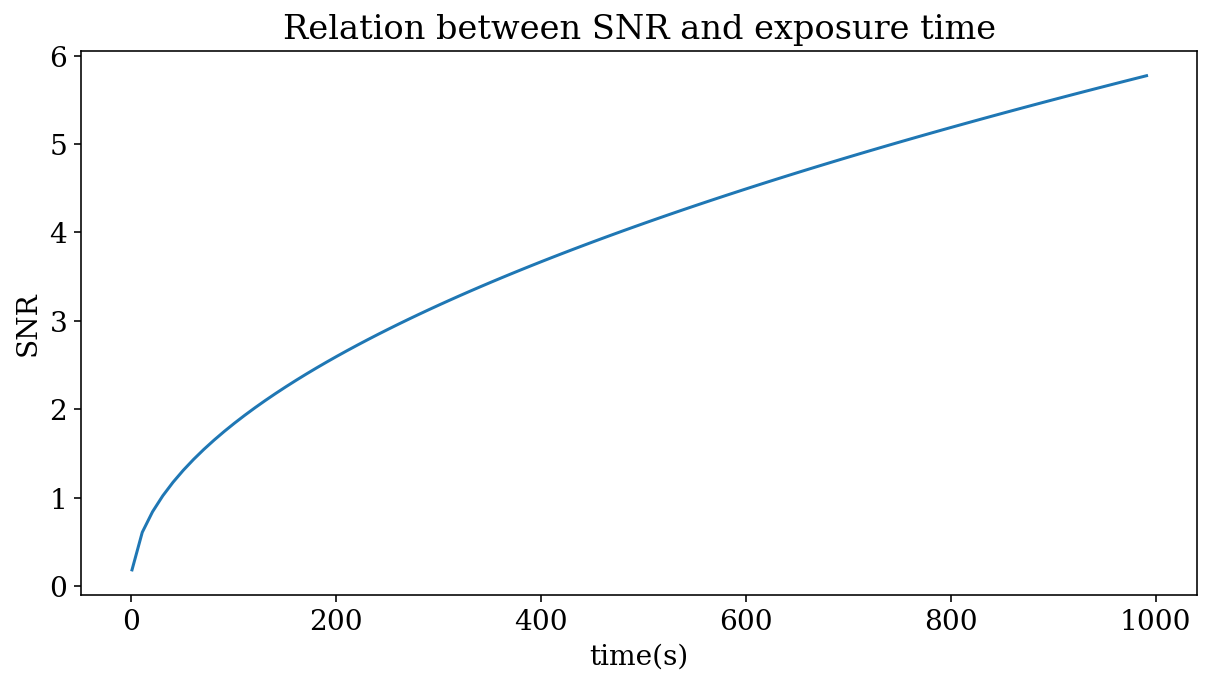

In [120]:
t=np.arange(1, 1000, 10)
n = 2.333 * 10**3
S_B = 0.1
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)


# FSR0614

In [121]:
#FSR catalogue

FSR = 'FSR_catalog.fits'

file = fits.open(FSR)
data_FSR = file[1].data
header_FSR = file[1].header
file.close()

In [122]:
header_FSR

XTENSION= 'TABLE   '           / Ascii Table Extension                          
BITPIX  =                    8 / Character data                                 
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                  224 / Number of bytes per record                     
NAXIS2  =                10348 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                   27 / Number of data fields (columns)                
EQUINOX =               2000.0 / Equinox of coordinates (J system)              
EPOCH   =               2000.0 / Epoch of coordinates                           
EXTNAME = 'stars_q2/*'         / *Star catalogs for 650 sky areas               
COMMENT  Note on stars_q2/*: The file names include the MWSC sequential number  
         and a name of a clu

In [123]:
mask_V = data_FSR.field('Vmag    ')>-99.99

new_FSR_data = data_FSR[mask_V]
V_ordered = np.sort(new_FSR_data.field('Vmag    '))
print(V_ordered)
print(np.mean(V_ordered))

[ 8.27   8.54   8.623 ... 18.8   18.9   19.   ]
16.741416728902163


In [125]:
m_max = 8.27
m_avg = 16.7

S = electron_rate_ADU(m_avg)
print(S)


3.0718722641867493


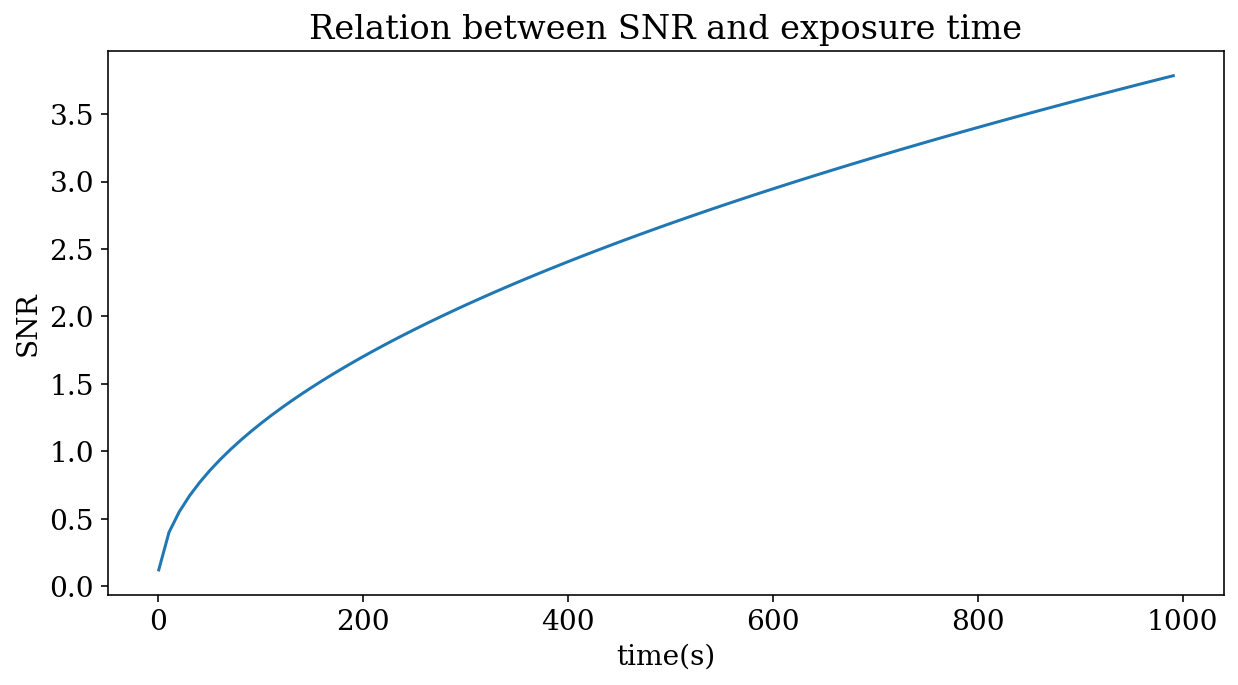

In [126]:
t=np.arange(1, 1000, 10)
n = 2.166 * 10**3
S_B = 0.1
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)